# Topic Modeling (Working Script)
## Importing Packages and Pre-Processing

In [2]:
import pandas as pd
import spacy
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel, HdpModel
from gensim.models.nmf import Nmf
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [3]:
# Loading cleaned version of the data set
DF = pd.read_csv('Data/CleanedTweets.csv')

DF.head()

In [5]:
# Loading spacy
nlp = spacy.load("en_core_web_sm", parser = False)

## load the current list of prefixes & remove # from the list 
## (keep hastags in tact)
prefixes = list(nlp.Defaults.prefixes)
prefixes.remove('#')

## recompile a new prefix regex with the smaller list of prefixes
prefix_regex = spacy.util.compile_prefix_regex(prefixes)
## set the tokenizer prefix_search to use the search of the newly compiled regex
nlp.tokenizer.prefix_search = prefix_regex.search

In [7]:
# Defining function that will remove unwanted tokens. It is a bit different from
# the function used in authorship detection, since I want to remove stop words
# but keep hashtags and mentions
# (stop words can be useful to identify authors, but will clutter up the topics)

def keepChars(tweet):
    '''
    Cleans an invididual tweet by removing non-character features, any url link, 
    etc. Designed to be used with a map function.
    Input: tweet (list of tokens)
    Output: charTweet (list of tokens)
    '''
    ## initialize a list to store the characters only
    charTweet = []
    
    for token in tweet:
        ## remove token if it contains a url link
        if 'http' in token.text:
            continue
        
        ## remove token if it is 'amp'
        if token.text == 'amp':
            continue
        
        ## remove token if it is punctuation, stop word, or space
        if token.is_punct or token.is_stop or token.is_space:
            continue
        
        ## remove token if it is less than one character long
        elif len(token.text) < 2:
            continue
        
        ## append the new lemmatized and lowered token to the character only token list
        else:
            charTweet.append(token.lemma_.lower())
        
    return charTweet

In [8]:
## tokenize every tweet in the dataframe & adding a new column in the process
DF['Tokens'] = DF['FullText'].apply(lambda x: nlp.tokenizer(x))
DF['TextOnly'] = DF['Tokens'].map(keepChars)

DF.head()

## LDA

In [12]:
# Changing pandas series to list of lists for gensim LDA
texts = list(DF['TextOnly'])

# Create the dictionary
dictionary = corpora.Dictionary(texts)

# Gensim LDA stores all the text for processing into a corpus object. 
# All text is filtered through the previously constructed dictionary.
corpus = [dictionary.doc2bow(text) for text in texts]

In [19]:
# For this first example, I'm going to choose 8 topics to see how it's working,
# even though that may not be the best choice.
total_topics = 8

# Experiment with the alpha assingment to investigate alpha parameter settings on topic assignments
#lda_alpha = 'auto' #learns asymmetic prior from the corpus
lda_alpha = 'symmetric'
#lda_alpha = 'asymmetric'  # sets alpha = 1 / number_of_topics

lda1 = models.LdaModel(corpus,
                       id2word = dictionary,
                       num_topics = total_topics,
                       iterations = 1000,
                       alpha=lda_alpha,
                       random_state=1)

In [21]:
#Show first n=10 important words in the topics:
topics = lda1.show_topics(total_topics, 10)

for topic in topics:
    topic_num = topic[0]
    topic_tokens = topic[1]
    print(f'Topic {topic_num}')
    print(f'{topic_tokens}\n')

Topic 0
0.019*"debate" + 0.018*"help" + 0.014*"day" + 0.013*"tulsi" + 0.013*"thank" + 0.012*"donor" + 0.010*"let" + 0.010*"tonight" + 0.009*"need" + 0.009*"donate"

Topic 1
0.038*"trump" + 0.024*"american" + 0.020*"president" + 0.019*"war" + 0.014*"donald" + 0.011*"people" + 0.011*"end" + 0.008*"need" + 0.008*"policy" + 0.008*"care"

Topic 2
0.016*"thank" + 0.013*"work" + 0.012*"stand" + 0.012*"fight" + 0.011*"worker" + 0.010*"family" + 0.009*"service" + 0.009*"support" + 0.009*"wage" + 0.009*"country"

Topic 3
0.030*"war" + 0.024*"#tulsi2020" + 0.021*"new" + 0.012*"troop" + 0.009*"right" + 0.009*"american" + 0.009*"iraq" + 0.008*"military" + 0.007*"iran" + 0.007*"protect"

Topic 4
0.017*"country" + 0.012*"people" + 0.011*"work" + 0.010*"president" + 0.010*"need" + 0.009*"world" + 0.009*"america" + 0.007*"well" + 0.007*"year" + 0.007*"government"

Topic 5
0.023*"people" + 0.016*"tulsi" + 0.015*"american" + 0.015*"#tulsi2020" + 0.014*"live" + 0.012*"country" + 0.012*"president" + 0.010*

From the above lists of words, we see some topics forming like:

3. War in the Middle East
5. Tulsi Gabbard
6. Climate change

However, other topics are harder to discern and use a lot of general political words like "people", "country", "american", and "president".
I'm going to remove those and then try different numbers of topics.

In [22]:
# Removing some general political words
remove_list = ["people", "country", "american", "america", "president", "thank"]
texts_rm = [[token for token in tweet if token not in remove_list] for tweet in texts] 

# Create dictionary
dictionary_rm = corpora.Dictionary(texts_rm)

# Gensim LDA stores all the text for processing into a corpus object. 
# All text is filtered through the previously constructed dictionary.
corpus_rm = [dictionary_rm.doc2bow(text) for text in texts_rm]

In [23]:
# Tuning hyperparameters (number of topics, alpha):
# Looking for the model with minimum perplexity and maximium topic coherence.

### This takes a while to run!

perplexity_lda = []
coherence_lda = []
topic_count_lda = []
alpha_options = ['auto', 'symmetric', 'asymmetric']
alpha_option_lda = []

for num_topics in range(5, 21, 1):
    for lda_alpha in alpha_options:

        print(f"Computing the lda model using {num_topics} topics and {lda_alpha} alpha.")

        topic_lda = models.LdaModel(corpus_rm,
                                    id2word = dictionary_rm,
                                    num_topics = num_topics,
                                    iterations = 1000,
                                    alpha = lda_alpha,
                                    random_state=1)

        topic_count_lda.append(num_topics)
        
        alpha_option_lda.append(lda_alpha)

        # a measure of how good the model is. lower the better.
        perplexity_lda.append(topic_lda.log_perplexity(corpus_rm))

        # Compute Coherence Score
        cm = CoherenceModel(model=topic_lda, corpus=corpus_rm, dictionary=dictionary_rm, coherence='u_mass')
        coherence_lda.append(cm.get_coherence())

Computing the lda model using 5 topics and auto alpha.
Computing the lda model using 5 topics and symmetric alpha.
Computing the lda model using 5 topics and asymmetric alpha.
Computing the lda model using 6 topics and auto alpha.
Computing the lda model using 6 topics and symmetric alpha.
Computing the lda model using 6 topics and asymmetric alpha.
Computing the lda model using 7 topics and auto alpha.
Computing the lda model using 7 topics and symmetric alpha.
Computing the lda model using 7 topics and asymmetric alpha.
Computing the lda model using 8 topics and auto alpha.
Computing the lda model using 8 topics and symmetric alpha.
Computing the lda model using 8 topics and asymmetric alpha.
Computing the lda model using 9 topics and auto alpha.
Computing the lda model using 9 topics and symmetric alpha.
Computing the lda model using 9 topics and asymmetric alpha.
Computing the lda model using 10 topics and auto alpha.
Computing the lda model using 10 topics and symmetric alpha.
Com

In [24]:
### Creating a dataframe to plot perplexity and coherence

# Create a list that combines the number of topics with the alpha option
model_type = [i+', '+j for i, j in zip([str(k) for k in topic_count_lda], [m[0:4] for m in alpha_option_lda])] 

# Pull the resulting data into a pandas dataframe
topics_lda = pd.DataFrame({'num_topics':topic_count_lda,
                           'alpha':alpha_option_lda,
                           'perplexity': perplexity_lda,
                           'coherence': coherence_lda,
                          'model_type': model_type}
                         )

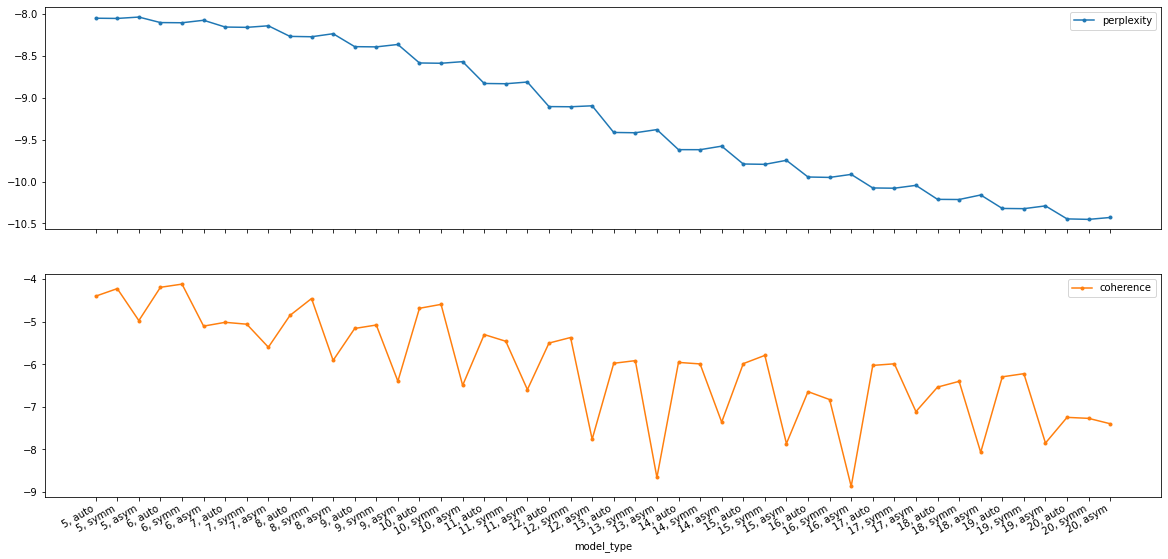

In [25]:
# Graphing perplexity and topic coherence for every model type
topics_lda.plot.line(x='model_type', y=['perplexity', 'coherence'],
                             marker='.', subplots = True, figsize=(20,10))
plt.xticks(range(len(topics_lda.model_type)), topics_lda.model_type)
plt.show()

From the above plot, we can see that perplexity and coherence both decrease as the number of topics increases. We want a low perplexity but a high coherence, so we will have to balance the two.

Here are two models that strike a good balance because their coherence scores are slightly higher than surrounding models. I will investigate these further:

1. Model with `num_topics = 10` and `alpha = symmetric`
2. Model with `num_topics = 17` and `alpha = auto`

In [26]:
# Model 1: 10 topics, symmetric alpha

total_topics = 10
lda_alpha = 'symmetric'

lda1 = models.LdaModel(corpus_rm,
                       id2word = dictionary_rm,
                       num_topics = total_topics,
                       iterations = 1000,
                       alpha = lda_alpha,
                       random_state = 1)

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda1, corpus_rm, dictionary_rm, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      32.420952   8.115230       1        1  14.141946
4       0.648955  71.707100       2        1  12.704369
3      71.019684   9.971006       3        1  12.490041
0       3.785981  33.185135       4        1  11.999151
9     -42.666500  -9.222070       5        1   8.957781
6      -3.621689 -43.526516       6        1   8.609930
5      -3.632402  -4.171708       7        1   8.021492
7     -36.584400  35.804413       8        1   7.818149
1      44.391380  50.615383       9        1   7.692446
8      40.235809 -31.591665      10        1   7.564695, topic_info=         Term         Freq        Total Category  logprob  loglift
6669    tulsi   773.000000   773.000000  Default  30.0000  30.0000
113   climate  1025.000000  1025.000000  Default  29.0000  29.0000
112    change  1106.000000  1106.000000  Default  28.0000  28.0000
76      trump  1999.000000  1999.000000  Default  27.0000  27.0000
973       war  1342.000000  1342.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
253   support   102.693893   842.294706  Topic10  -4.9364   0.4773
467      talk    79.097013   322.654929  Topic10  -5.1974   1.1758
418    family    82.452527   805.257608  Topic10  -5.1559   0.3027
25       know    81.055858   705.362411  Topic10  -5.1730   0.4181
178      join    79.159460   762.472665  Topic10  -5.1966   0.3166

[732 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
108       3  0.971285          #1
453       1  0.286616  #demdebate
453       2  0.164472  #demdebate
453       3  0.100376  #demdebate
453       4  0.128191  #demdebate
...     ...       ...         ...
87        7  0.045936        year
87        8  0.015312        year
87        9  0.028072        year
87       10  0.026796        year
328       4  0.980663       youth

[2208 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 1, 10, 7, 6, 8, 2, 9])

In [27]:
# Model 2: 17 topics, auto alpha

total_topics = 17
lda_alpha = 'auto'

lda2 = models.LdaModel(corpus_rm,
                       id2word = dictionary_rm,
                       num_topics = total_topics,
                       iterations = 1000,
                       alpha = lda_alpha,
                       random_state = 1)

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda2, corpus_rm, dictionary_rm, mds='tsne')
panel

PreparedData(topic_coordinates=               x           y  topics  cluster      Freq
topic                                                  
9       2.972113  -13.786730       1        1  8.795946
2      -7.288966   86.150291       2        1  7.821312
0      38.049393   65.587624       3        1  7.646861
14    -42.227043    6.162611       4        1  7.571274
4     -63.238548  -41.294518       5        1  7.485192
11    -48.099060   56.473579       6        1  7.104628
5     -48.087841  120.044159       7        1  6.414064
7      17.708776  131.640900       8        1  6.251816
3      92.846191   -8.328438       9        1  6.241112
15     47.892864  -45.589878      10        1  5.109604
10     92.039185   50.145565      11        1  4.837925
6     -94.766495   15.104293      12        1  4.805909
13     -9.109381  -64.732552      13        1  4.693609
12    -94.606842   77.712318      14        1  4.664948
1      44.945538   14.845922      15        1  4.208708
16     -1.493484   35.842178      16        1  3.350620
8      71.312836  105.574364      17        1  2.996472, topic_info=            Term         Freq        Total Category  logprob  loglift
973          war  1362.000000  1362.000000  Default  30.0000  30.0000
113      climate  1021.000000  1021.000000  Default  29.0000  29.0000
76         trump  2087.000000  2087.000000  Default  28.0000  28.0000
112       change  1086.000000  1086.000000  Default  27.0000  27.0000
2282     freedom   317.000000   317.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
973          war    61.605653  1362.830818  Topic17  -4.5213   0.4112
119          let    49.920067   703.577139  Topic17  -4.7316   0.8620
25          know    37.648364   742.397034  Topic17  -5.0138   0.5261
179         time    36.478030  1021.868186  Topic17  -5.0453   0.1751
453   #demdebate    35.830828   871.599557  Topic17  -5.0632   0.3162

[1135 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
108       6  0.896417         #1
108      16  0.040746         #1
983       3  0.606000  #aapi2020
983       4  0.377766  #aapi2020
983       8  0.007870  #aapi2020
...     ...       ...        ...
1222      9  0.020683        yes
1222     13  0.031025        yes
1222     14  0.661868        yes
1222     15  0.124100        yes
328       3  0.970439      youth

[4028 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 3, 1, 15, 5, 12, 6, 8, 4, 16, 11, 7, 14, 13, 2, 17, 9])

In [ ]:
# TALK ABOUT WHICH MODEL SEEMS BETTER, WHAT THE TOPICS ARE

## NMF

In [45]:
# In NNMF factorization we will use term-frequency-inverse_document-frequency for weighting the term document matrix
tfidf = models.TfidfModel(corpus_rm) # step 1 -- initialize a model
corpus_tfidf = tfidf[corpus_rm]      # step 2 -- use the model to transform vectors

In [59]:
# Finding NMF model with the highest topic coherence

### This takes a while to run!

coherence_nmf = []
topic_count_nmf = []

for num_topics in range(5, 21, 1):

    print(f"Computing the NMF model using {num_topics} topics")

    nmf = Nmf(corpus_tfidf,
              id2word = dictionary_rm,
              passes = 20,
              num_topics = num_topics,
              random_state = 1)

    topic_count_nmf.append(num_topics)

    # Compute Coherence Score
    cm = CoherenceModel(model=nmf, corpus=corpus_rm, dictionary=dictionary_rm, coherence='u_mass')
    coherence_nmf.append(cm.get_coherence())

Computing the NMF model using 5 topics
Computing the NMF model using 6 topics
Computing the NMF model using 7 topics
Computing the NMF model using 8 topics
Computing the NMF model using 9 topics
Computing the NMF model using 10 topics
Computing the NMF model using 11 topics
Computing the NMF model using 12 topics
Computing the NMF model using 13 topics
Computing the NMF model using 14 topics
Computing the NMF model using 15 topics
Computing the NMF model using 16 topics
Computing the NMF model using 17 topics
Computing the NMF model using 18 topics
Computing the NMF model using 19 topics
Computing the NMF model using 20 topics


In [60]:
### Creating a dataframe to plot coherence

topics_nmf = pd.DataFrame({'num_topics':topic_count_nmf,
                           'coherence': coherence_nmf})

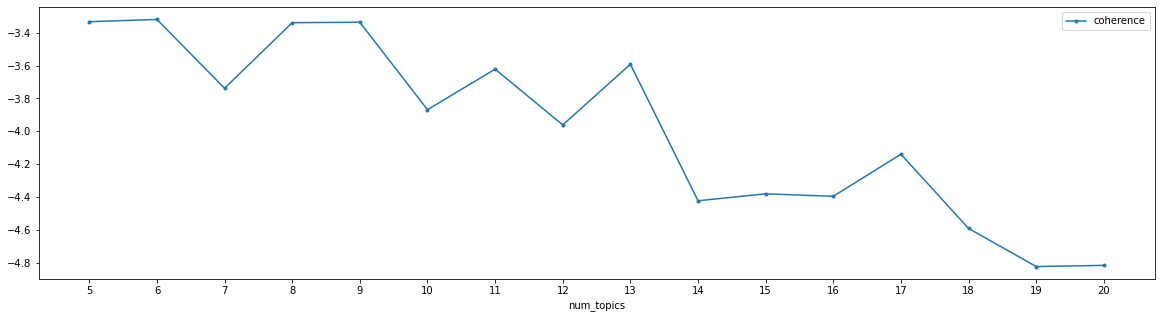

In [61]:
# Graphing perplexity and topic coherence for every model type
topics_nmf.plot.line(x='num_topics', y='coherence',
                             marker='.', figsize=(20,5))
plt.xticks(range(5,21), topics_nmf.num_topics)
plt.show()

From the above plot, we can see that the models with `num_topics` equal to 5, 6, 8, or 9 have the highest coherence scores. 

I'm going to investigate `num_topics = 9` further, since one of the LDA models used 10 topics.

In [62]:
num_topics = 9

nmf1 = Nmf(corpus_tfidf,
              id2word = dictionary_rm,
              passes = 20,
              num_topics = num_topics,
              random_state = 1)

# Show first n=10 important words in the topics:
topics = nmf1.show_topics(num_topics, num_words = 10)

for topic in topics:
    topic_num = topic[0]
    topic_tokens = topic[1]
    print(f'Topic {topic_num}')
    print(f'{topic_tokens}\n')

Topic 0
0.012*"time" + 0.011*"know" + 0.011*"trump" + 0.009*"house" + 0.009*"white" + 0.009*"come" + 0.008*"election" + 0.008*"need" + 0.007*"democracy" + 0.007*"united"

Topic 1
0.077*"win" + 0.044*"big" + 0.028*"fight" + 0.016*"structural" + 0.015*"2020" + 0.013*"hard" + 0.012*"dream" + 0.012*"bring" + 0.011*"election" + 0.010*"iowa"

Topic 2
0.022*"new" + 0.017*"chip" + 0.017*"help" + 0.016*"hampshire" + 0.015*"campaign" + 0.013*"day" + 0.010*"iowa" + 0.010*"tonight" + 0.008*"today" + 0.008*"join"

Topic 3
0.058*"#demdebate" + 0.015*"well" + 0.014*"right" + 0.013*"stage" + 0.011*"thing" + 0.010*"change" + 0.010*"good" + 0.010*"ready" + 0.010*"big" + 0.008*"idea"

Topic 4
0.027*"fight" + 0.027*"worker" + 0.022*"stand" + 0.016*"work" + 0.016*"union" + 0.014*"right" + 0.012*"wage" + 0.011*"deserve" + 0.010*"proud" + 0.010*"fair"

Topic 5
0.049*"care" + 0.046*"health" + 0.015*"medicare" + 0.014*"plan" + 0.012*"affordable" + 0.009*"cost" + 0.009*"insurance" + 0.009*"need" + 0.009*"family

In [ ]:
# TALK ABOUT WHAT THE TOPICS ARE

### Visualize Topics Used by Candidates